In [13]:
%load_ext autoreload
%autoreload 2

import random
import numpy as np
import pandas as pd
import IPython.display as dp

from jassbot.Config import *
from jassbot.GameLogic import *
from jassbot.GameStrategy import *

create_logger()

model = create_model()
stats = pd.DataFrame({'rounds won':[], 'games won':[]})

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
state = init()
new_game(state)
print_state(state)
while len(state['played']) < 36:
    play_round(state)
print_state(state)

In [ ]:
state = init()
new_game(state)
print_state(state)
play_round(state, lambda cards: random.choice(cards))
play_round(state, lambda cards: random.choice(cards))
print_state(state)

In [27]:
state = init()
epsilon = 1
epochs = 100

test_runs = 100

simulations = 2
logger = get_logger()

for s in range(simulations):

    temp_memory = []
    round_wins = []
    print('*** learning phase %i / %i' % (s+1, simulations))
    for epoch in range(epochs):
        new_game(state)
        logger.info("*** start of a new game")
        print_state(state)

        for j in range(9):
            for i in range(4):
                result = play_once(state, lambda (possible_cards): \
                          choose(state,possible_cards,model,temp_memory,epsilon))

                assert i < 3 and result is None or \
                       i == 3 and result is not None

                if i == 3: # at the end of one round

                    round_wins.append(result)

                    if len(state['played']) == 36: 

                        # the game is finished, we can update the model
                        update_model_game_end(model,temp_memory,round_wins,epsilon)

    game_wins = pd.DataFrame({'game won':[]})
    round_wins = pd.DataFrame({'round won':[]})

    print('*** testing phase %i / %i' % (s+1, simulations))
    game_wins_idx = 0
    round_wins_idx = 0
    for epoch in range(test_runs):
        new_game(state)
        logger.info("*** start of a new game")
        print_state(state)

        for j in range(4*9):
            result = play_once(state, lambda (possible_cards): \
                      choose_for_test(state,possible_cards,model,temp_memory,epsilon))

            if result is not None:
                team = result['team']
                is_final = result['final']

                if is_final:
                    ratio = result['ratio']
                    df = pd.DataFrame({'game won':[1 if team == 0 else 0], 'ratio': [ratio]}, index=[game_wins_idx])
                    game_wins = game_wins.append(df)
                    game_wins_idx += 1
                else:
                    df = pd.DataFrame({'round won':[1 if team == 0 else 0]}, index=[round_wins_idx])
                    round_wins = round_wins.append(df)
                    round_wins_idx += 1


    games_won = 1.0 * len(game_wins[game_wins['game won'] == 1]) / test_runs
    ratio = game_wins['ratio'].mean()

    # we have 8 rounds, excepted the final one that we don't count here
    rounds_won = 1.0 * len(round_wins[round_wins['round won'] == 1]) / (test_runs * 8)
    
    df = pd.DataFrame({'rounds won':[rounds_won], 'games won':[games_won], 'ratio':[ratio]},index=[s])
    dp.display(df)
    stats = stats.append(df)
    
    if epsilon > 0.1:
        epsilon -= (1/simulations)

stats

*** learning phase 1 / 2
*** testing phase 1 / 2


,games won,ratio,rounds won
0,0.47,0.47,0.5075


*** learning phase 2 / 2
*** testing phase 2 / 2


,games won,ratio,rounds won
1,0.51,0.51,0.5175


,games won,ratio,rounds won
0,0.45,0.45,0.50375
1,0.46,0.46,0.50875
0,0.47,0.47,0.50750
1,0.51,0.51,0.51750


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_7 (Dense)                  (None, 220)           24420       dense_input_3[0][0]              
____________________________________________________________________________________________________
activation_7 (Activation)        (None, 220)           0           dense_7[0][0]                    
____________________________________________________________________________________________________
dense_8 (Dense)                  (None, 300)           66300       activation_7[0][0]               
____________________________________________________________________________________________________
activation_8 (Activation)        (None, 300)           0           dense_8[0][0]                    
___________________________________________________________________________________________

0.5422166666666666

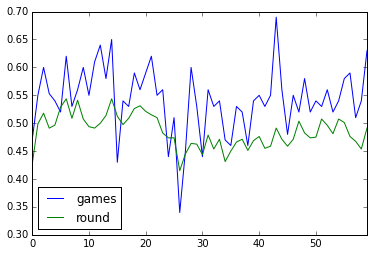

In [23]:
model.summary()
#stats.astype(float)

games_won = [0.470,
0.550,
0.600,
0.553,
0.540,
0.520,
0.620,
0.530,
0.560,
0.600,
0.550,
0.610,
0.640,
0.580,
0.650,
0.430,
0.540,
0.530,
0.590,
0.560,
0.590,
0.620,
0.550,
0.560,
0.440,
0.510,
0.340,
0.450,
0.600,
0.530,
0.440,
0.560,
0.530,
0.540,
0.470,
0.460,
0.530,
0.520,
0.460,
0.540,
0.550,
0.530,
0.550,
0.690,
0.560,
0.480,
0.550,
0.520,
0.580,
0.520,
0.540,
0.530,
0.560,
0.520,
0.540,
0.580,
0.590,
0.510,
0.540,
0.630]

rounds_won = [
0.426250,
0.498750,
0.518000,
0.491125,
0.496625,
0.528750,
0.543750,
0.508750,
0.541250,
0.507500,
0.493750,
0.491250,
0.500000,
0.513750,
0.543750,
0.512500,
0.497500,
0.508750,
0.526250,
0.531250,
0.521250,
0.515000,
0.510000,
0.482500,
0.473750,
0.473750,
0.415000,
0.445000,
0.463750,
0.462500,
0.443750,
0.478750,
0.453750,
0.471250,
0.431250,
0.450000,
0.466250,
0.471250,
0.451250,
0.468750,
0.476250,
0.455000,
0.458750,
0.491250,
0.471250,
0.458750,
0.471250,
0.503750,
0.482500,
0.473750,
0.475000,
0.507500,
0.496250,
0.481250,
0.507500,
0.501250,
0.476250,
0.467500,
0.453750,
0.491250
]

df = pd.DataFrame({'games': games_won, 'round': rounds_won}, index=range(len(games_won)))
df.plot()

df['games'].mean()